In [1]:
# Dependencies - General Stuff
import numpy as np
import importlib
import tempfile
from scipy.signal import find_peaks

# strfpy
from strfpy import preprocSound, strfSetup, trnDirectFit, calcSegmentedModel
from strfpy.timeFreq import timefreq_raw
from soundsig.sound import spec_colormap

import pynwb
from matplotlib import pyplot as plt
# %matplotlib widget
plt.ion()

#### Read the data file

In [74]:
# nwb_file = '/aquila_ssd2/lthomas/songephys_data/OperantEphys/HpiPur2667F/sites/HpiPur2667F_site02_240905_072851_pb_op/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'

nwb_file = '/Users/frederictheunissen/Working Data/OperantEphys/NWB_Files/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'
# Load the nwb file
preprocOptions = {} # we'll leave this empty and use default options
nwb_io =  pynwb.NWBHDF5IO(nwb_file, mode='r')
nwb = nwb_io.read()
units = nwb.units.to_dataframe()
# load the good units
good_units = units[units.group == 'good']


In [75]:
# sample a random unit
unit = good_units.sample().iloc[0]
unit = good_units.iloc[10]       # This is a good example for a neuron with strong onset-offset response - positive onset and negative offset
# unit = good_units.iloc[7]
print("Processing unit: ", unit.name)

Processing unit:  19


### Plot the stim and microphone data of a random playback trial

In [76]:
def get_mic_data(nwb, trial):
    rate = nwb.acquisition['audio'].rate
    mic_data = nwb.acquisition['audio'].data
    start_id = int(trial.start_time * rate)
    end_id = int(trial.stop_time * rate)
    mic_trial = mic_data[start_id:end_id]
    return mic_trial[:,1], mic_trial[:,0]

In [77]:
# lets take one trial and compare the spectrogram to the spectrogram of the microphone data
# lets get a ranodm trial
trials = nwb.intervals['playback_trials'].to_dataframe()

Repeat the cell below to get another example

Text(0.5, 0, 'Time (s)')

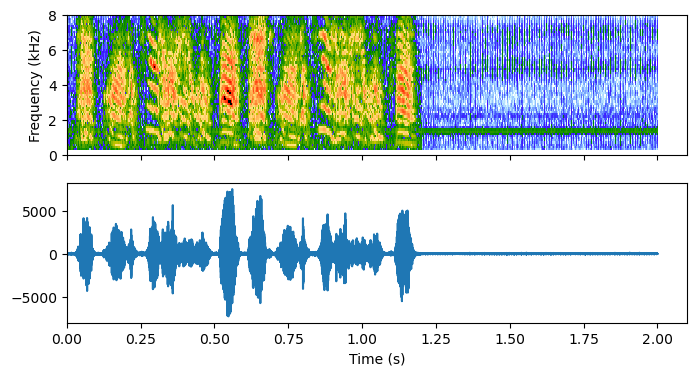

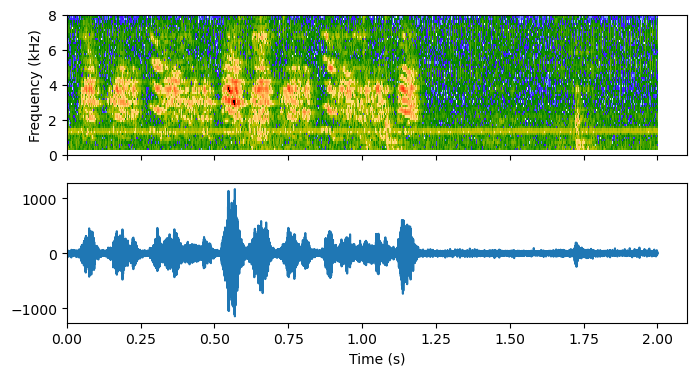

In [78]:
# Choose a ramdom trial
trial = trials.sample().iloc[0]
mic_trial, mic_copy = get_mic_data(nwb, trial)
rate = nwb.acquisition['audio'].rate

# Spectrogram paramteters.
stim_params = {}
stim_params['fband'] = 120
stim_params['nstd'] = 6
stim_params['high_freq'] = 8000
stim_params['low_freq'] = 250
stim_params['log'] = 1
stim_params['stim_rate'] = 1000  # Sample rate of spectrogram
DBNOISE = 80
# Colormap for plotting spectrograms
spec_colormap()   # defined in sound.py


# First figure for the microphone copy
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

tfrep = timefreq_raw(mic_copy, rate, 'ft', params=stim_params)
cmap = plt.get_cmap('SpectroColorMap')

minSpect = tfrep['spec'].max()-DBNOISE
maxB = tfrep['spec'].max()
ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

tval = np.arange(stop=len(mic_copy))/rate
ax2.plot(tval, mic_copy)
ax2.set_xlabel('Time (s)')

# Second copy for the microphone 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

tfrep = timefreq_raw(mic_trial, rate, 'ft', params=stim_params)
minSpect = tfrep['spec'].max()-DBNOISE
maxB = tfrep['spec'].max()
ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

tval = np.arange(stop=len(mic_trial))/rate
ax2.plot(tval, mic_trial)
ax2.set_xlabel('Time (s)')



### Create a stimulus-response data set

In [79]:
# Preprocess sound stimulus and segment

respChunkLen = 100 # ms of stim to use in each chunk of feature space
segmentBuffer = 30 # ms to add at the beginning of each segment
nLaguerre = 25 # number of laguerre functions to use
feature = 'spect_windows'
event_types = 'onoff_feature'
nPoints = 150 # number of points to use in the kernel

srData = preprocSound.preprocess_sound_nwb(nwb_file, 'playback_trials', unit.name, preprocess_type='ft')
calcSegmentedModel.preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False)

print('This playback stim-response data set has %d stimuli.' % (len(srData['datasets'])))


              kilosort_dir  kilosort_id group       ks_x        ks_y  \
id                                                                     
19  ks4_lat_250215/shank_0           38  good  11.247663  223.116302   

                                          spike_times electrodes  
id                                                                
19  [0.24823333333333333, 0.25783333333333336, 0.4...        [3]  


/Users/frederictheunissen/Code/strfPy/module/strfpy/timeFreq.py:29: RuntimeWarning: divide by zero encountered in log10
  normedS = 20 * np.log10(normedS)


This playback stim-response data set has 41 stimuli.


In [80]:
## truncate the data set
maxDataSets = 3

if (len(srData['datasets']) > maxDataSets):
    del srData['datasets'][maxDataSets-1:-1]

In [81]:
print(len(srData['datasets']))

3


In [82]:
# Estimate the single trial SNR for this data set
snr = preprocSound.estimate_SNR(srData)
print('The single trial SNR is %.4f' % (snr))
print('The corresponding EV for 10 trials is %.4f' % (10*snr/(10*snr + 1)))

The single trial SNR is 1.1955
The corresponding EV for 10 trials is 0.9228


In [83]:
# Calculate the average response at onsets and offsets

meansOnOff = np.zeros((2,nPoints))
nEventsOnOff = np.zeros((2,nPoints))
responseAvg = 0
stimLenTot = 0
for ds in srData['datasets']:
    events = ds['events']
    nEvents = len(events['index'])
    y = ds['resp']['psth_smooth']
    if "weights" not in ds["resp"]:
        yw = np.ones_like(y)
    else:
        yw =ds["resp"]["weights"]
    y = y[yw > 0]
    yw = yw[yw > 0]

    responseAvg += np.sum(y*yw)
    stimLenTot += np.sum(yw)
    stimLen = len(yw)
    for iEvent in range(nEvents):
        startInd = events['index'][iEvent]        
        if (startInd >= stimLen):
            break

        endInd = startInd + nPoints
        if (endInd>stimLen):
            endInd = stimLen
            
        if (events['onoff_feature'][iEvent][0] == 1 ):
            meansOnOff[0,0:endInd-startInd] = meansOnOff[0,0:endInd-startInd] + y[startInd:endInd]*yw[startInd:endInd]
            nEventsOnOff[0,0:endInd-startInd] += yw[startInd:endInd]
        else:
            meansOnOff[1,0:endInd-startInd] = meansOnOff[1,0:endInd-startInd] + y[startInd:endInd]*yw[startInd:endInd]
            nEventsOnOff[1,0:endInd-startInd] += yw[startInd:endInd]

meansOnOff[0,:] /= nEventsOnOff[0,:]
meansOnOff[1,:] /= nEventsOnOff[1,:]
responseAvg /= stimLenTot

meansOnOff[0,:] -= responseAvg
meansOnOff[1,:] -= responseAvg



## FET Ridge

In [85]:
# Fit the segmentation (on-off here) kernel (impulse response)
segModel = calcSegmentedModel.fit_seg(srData, nPoints, x_feature = event_types, y_feature = 'psth_smooth', kernel = 'Kernel', nD=2, tol=np.array([0.1, 0.01, 0.001, 0.0001, 0.0001]), store_error = True )
learned_conv_kernel = segModel['weights'].reshape(2, nPoints)

In [86]:
raw_kernel = segModel['Cxy'].reshape(2, nPoints)
b0 = segModel['b0']
Cxx = segModel['Cxx']

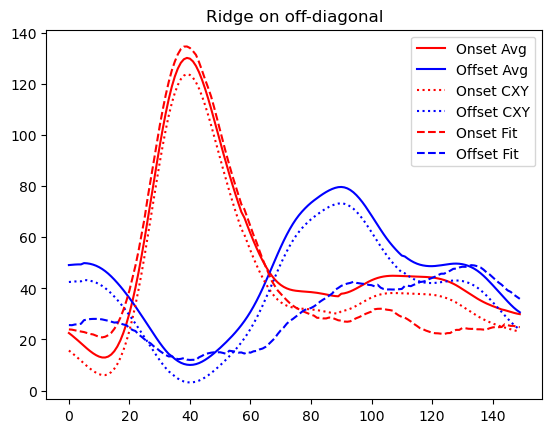

In [87]:
# Checking to see if our normalization works properfly

plt.plot(meansOnOff[0,:]+responseAvg, 'r', label='Onset Avg')
plt.plot(meansOnOff[1,:]+responseAvg, 'b', label='Offset Avg')
plt.plot(raw_kernel[0,:]*1/np.diag(Cxx)[0:nPoints]+b0, 'r:', label='Onset CXY')
plt.plot(raw_kernel[1,:]*1/np.diag(Cxx)[nPoints:]+b0, 'b:', label='Offset CXY')
plt.plot(learned_conv_kernel[0,:]+b0, 'r--', label='Onset Fit')
plt.plot(learned_conv_kernel[1,:]+b0, 'b--', label='Offset Fit')
plt.title('Ridge on off-diagonal')
plt.legend()

## Classic Ridge

In [88]:
# Fit the segmentation (on-off here) kernel (impulse response)
segModel0 = calcSegmentedModel.fit_seg(srData, nPoints, x_feature = event_types, y_feature = 'psth_smooth', kernel = 'Kernel0', nD=2, tol=np.array([0.1, 0.01, 0.001, 0.0001]), store_error = True )
learned_conv_kernel0 = segModel0['weights'].reshape(2, nPoints)

In [89]:
raw_kernel0 = segModel0['Cxy'].reshape(2, nPoints)
b0_0 = segModel0['b0']
Cxx_0 = segModel0['Cxx']

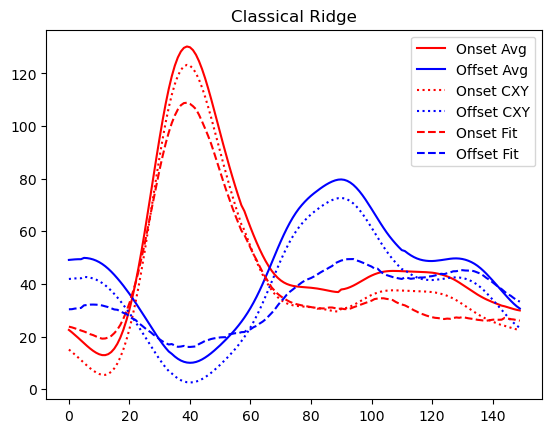

In [90]:
# Checking to see if our normalization works properfly

plt.plot(meansOnOff[0,:]+responseAvg, 'r', label='Onset Avg')
plt.plot(meansOnOff[1,:]+responseAvg, 'b', label='Offset Avg')
plt.plot(raw_kernel0[0,:]*1/np.diag(Cxx_0)[0:nPoints]+b0_0, 'r:', label='Onset CXY')
plt.plot(raw_kernel0[1,:]*1/np.diag(Cxx_0)[nPoints:]+b0_0, 'b:', label='Offset CXY')
plt.plot(learned_conv_kernel0[0,:]+b0_0, 'r--', label='Onset Fit')
plt.plot(learned_conv_kernel0[1,:]+b0_0, 'b--', label='Offset Fit')
plt.title('Classical Ridge')
plt.legend()

### Comparing the Impulse Responses Obtained with both

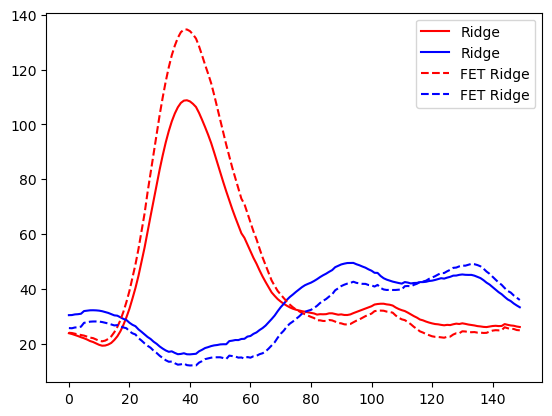

In [91]:
plt.plot(learned_conv_kernel0[0,:]+b0_0, 'r', label='Ridge')
plt.plot(learned_conv_kernel0[1,:]+b0_0, 'b', label='Ridge')
plt.plot(learned_conv_kernel[0,:]+b0, 'r--', label='FET Ridge')
plt.plot(learned_conv_kernel[1,:]+b0, 'b--', label='FET Ridge')
plt.legend()

In [92]:
print('R2CV for FET Ridge %.4f' % segModel['R2CV'].max())
print('R2CV for Ridge %.4f' % segModel0['R2CV'].max())

R2CV for FET Ridge 0.3768
R2CV for Ridge 0.3961


In [93]:
segModel['R2CV']

array([0.36851173, 0.37587553, 0.37664707, 0.37680507, 0.37680507])

In [94]:
segModel0['R2CV']

array([0.2339845 , 0.39612618, 0.3838026 , 0.37752745])